In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree    # Decision Tree
from sklearn.linear_model import LogisticRegression # LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC # Support Vector Machine 
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.feature_extraction.text as sk_text



## File Prep ##

In [89]:
%%time
column_names=['Name', 'ScreenName', 'UserID', 'FollowersCount', 'FriendsCount', 'Location', 'Description', 'CreatedAt', 'StatusID', 'Language', 'Place', 'RetweetCount', 'FavoriteCount', 'Text']
tweets = pd.read_csv('clinton_trump_tweets.txt', sep="\t",  encoding="ISO-8859-1", header=None, names=column_names)
#print initial data
tweets = tweets.drop(['ScreenName', 'FollowersCount', 'FriendsCount', 'CreatedAt', 'StatusID','Language', 'Place', 'RetweetCount', 'FavoriteCount'], axis=1)
tweets.Location = tweets.Location.astype(str)
tweets.Text = tweets.Text.astype(str)

ground_truth = pd.read_table('clinton_trump_user_classes.txt', encoding ="ISO-8859-1", dtype=int, names=["UserID", "TrumpOrClinton"])



CPU times: user 34 s, sys: 7.43 s, total: 41.4 s
Wall time: 42 s


### Task 1.1 (10 pts): Remove all retweets first. Remove all users that have less than 20 tweets. You may want to keep the entire tweet content, including hashtags/handles. ###

In [90]:
tweets = tweets[~tweets.Text.str.startswith('RT')]

In [91]:
%%time
def keepHashMentions(text):
    hashMentions = []
    for word in text:
        hashMentions.extend(word)
    return " ".join(hashMentions).strip()
## keeping tweet including hashtags and mentions here ## 
tweets['HashMentions'] = tweets.Text.str.findall('(@\w+)|(#\w+)').apply(keepHashMentions)


CPU times: user 14.4 s, sys: 1.13 s, total: 15.5 s
Wall time: 15.4 s


### Remove all users that have less than 20 tweets. ###

In [92]:
#1.2 keep tweets where UID appears 20+ times
tweets = tweets.groupby("UserID").filter(lambda x: len(x) >= 30)

In [93]:
%%timeit
# Generate a list of mention/hashes that have a frequency of 20+ #
top_hash = pd.Series(tweets['HashMentions'].str.cat(sep=' ').split()).value_counts()
top20 = top_hash[top_hash>=20]
top20List = top20.index.tolist()

# Convert list to set so it will have quick lookup
top20Set = set(top20List)


# generate list of mention/hashes that occur 20+ times from our orginal list 
def removeUnder20Mentions(hashMentions):
    mentions =  hashMentions.split()
    mentionsOver20 = []
    for mention in mentions:
        if(mention in top20Set):
            mentionsOver20.append(mention)
    return " ".join(mentionsOver20)
tweets['HashMentions'] = tweets.HashMentions.apply(removeUnder20Mentions)

1.73 s ± 9.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [94]:
hashMentionsMerged = tweets.groupby('UserID')['HashMentions'].apply(' '.join).reset_index()
tweetsWithNoHashMentions = tweets.drop('HashMentions', axis=1)
tweets = pd.merge(tweetsWithNoHashMentions, hashMentionsMerged, on='UserID')
tweets = tweets.drop_duplicates('UserID')


In [95]:
#remove users that have no hashtag/handles
tweets = tweets[tweets.HashMentions.apply(lambda x:  bool(x and x.strip()))]


In [96]:
# Remove locations that are null 
tweets['LocationCleaned'] = tweets['Location'].apply(lambda x: x.split(',')[0])
tweetsLocations = tweets[tweets['Location'].notnull()]
## manual cleanup of bad location data, fix later
tweetsLocations = tweetsLocations[tweetsLocations['LocationCleaned'] != 'NAN']
tweetsLocations = tweetsLocations[tweetsLocations['LocationCleaned'] != 'nan']
tweetsLocations = tweetsLocations[tweetsLocations['LocationCleaned'] != ' ']
tweetsLocations = tweetsLocations[tweetsLocations['LocationCleaned'] != '']

tweets = tweetsLocations[tweetsLocations['LocationCleaned'].isin(tweetsLocations['LocationCleaned'].value_counts().nlargest(150).index.tolist())]

# TODO: maybe try this later on with other locations
# tweetsLocations['LocationCleaned'] = tweetsLocations.LocationCleaned.map({'NYC':'New York','New York City':'New York','United States':'USA', 'United States of America': 'USA'})

In [97]:
aggregateTweetsHashtags = tweets.groupby('UserID')['HashMentions'].apply(lambda x: x.str.cat(sep=' '))
tweetsPrepareSKText = pd.DataFrame({'User_id': aggregateTweetsHashtags.index, 'All_hashtags': aggregateTweetsHashtags.values})
vectorizer = sk_text.TfidfVectorizer(max_features = 1000,
                             #min_df=100, 
                             #max_df=.8,
                             stop_words = 'english'
                             )
matrix = vectorizer.fit_transform(tweetsPrepareSKText.All_hashtags.values)
tdidf = matrix.toarray()
df_text = pd.DataFrame(matrix.todense(), index=aggregateTweetsHashtags.index, columns=vectorizer.get_feature_names())
df_text.head()

,039,0hour1__,100ktweets4safety,1a,2351onthelist,2a,2xshhhh,8217,8230,_kjrb_,...,wsjdlive,wwe,wwiii,wyoming,yahoonews,yesursjewelry,youranonnews,youtube,yusufdfi,zerohedge
UserID,,,,,,,,,,,,,,,,,,,,,
2391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
14763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1026541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1134681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.197194
1201691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [98]:
aggregateTweetsHashtags

UserID
2391                                    @MikeIsaac @fmanjoo ...
14763                #fall #nofilter #beauty    #fitness #tr...
1026541       #soccer    @WellsFargo  @Cubs #WorldSeries    ...
1134681       @SamHarrisOrg @Ayaan @MaajidNawaz @SamHarrisOr...
1201691         #SmallBusiness #success  #spon   #business #...
1252191        @NewsHour @BarackObama         @NewsHour  @Ne...
1253141          #sqlsummit  #sqlsummit  #sqlsummit #sqlsumm...
1428731          #2 #GoBlue #GoBlue #GoBlue      #GoBlue  @c...
1455431       #IBMWatson @OnStar  @OnStar @IBMWatson @GM #IB...
1459761                  @FastCompany #AI @FastCompany      ...
1477211                      #lol        @Twitter           ...
1496971                                                     ...
1525391                  @NRA           @jasoninthehouse    ...
1529611                          @YouTube        @YouTube  @...
1565041                                   @SNFonNBC  @JoelEm...
1628691         #Twitter  @twitte

### Vectorize Description ###

In [101]:
vectorizerDescription = sk_text.TfidfVectorizer(max_features = 1000,
                             #min_df=100, 
                             #max_df=.8,
                             stop_words = ['UserID']                
                            )
tweets = tweets[tweets['Description'].notnull()]

matrixDescription = vectorizerDescription.fit_transform(tweets.Description.values)
tdidfDescription = matrixDescription.toarray()
df_text_Description = pd.DataFrame(matrixDescription.todense(), index=tweets.UserID, columns=vectorizerDescription.get_feature_names())
df_text_Description.head()



,10,100,11,12,14,15,16,17,18,1st,...,years,yes,yet,york,you,young,your,youtube,youtuber,yrs
UserID,,,,,,,,,,,,,,,,,,,,,
106568768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2447279666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
231921777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201499452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17547533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Vectorize Description ###

In [103]:
vectorizerLocation = sk_text.TfidfVectorizer(max_features = 1000,
                             #min_df=100, 
                             #max_df=.8,
                             stop_words = ['UserID']                
                            )
tweets = tweets[tweets['LocationCleaned'].notnull()]

matrixLocation = vectorizerLocation.fit_transform(tweets.LocationCleaned.values)
tdidfLocation = matrixDescription.toarray()
df_text_Location = pd.DataFrame(matrixLocation.todense(), index=tweets.UserID, columns=vectorizerLocation.get_feature_names())
df_text_Location.head()



,alabama,america,angeles,ann,antonio,arbor,area,arizona,arlington,atlanta,...,usa,vancouver,vegas,virginia,washington,west,wisconsin,worldwide,worth,york
UserID,,,,,,,,,,,,,,,,,,,,,
106568768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2447279666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
231921777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
201499452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.531142
17547533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## Apply ground truths column to UserID of tweets Dataframe ##

In [104]:
#mergeGroundTruths = pd.merge(tweets, ground_truth, on = 'UserID')
#ground truth
dataFrameWithHashTagHandlesAndTruths = pd.merge(df_text,ground_truth, on = 'UserID')


##merge Description and Location into out dataframe 
dataFrameWithHashTagHandlesAndTruths = pd.merge(dataFrameWithHashTagHandlesAndTruths,df_text_Description,on = 'UserID')

dataFrameWithHashTagHandlesAndTruths = pd.merge(dataFrameWithHashTagHandlesAndTruths,df_text_Location,on = 'UserID')




## Implementing Logistic Regression on Location column, rest of models are below ##

### 1.1: Use train_test_split() to split data into training and test sets, where 20 percent of the records go to test set. ###

In [105]:
X = dataFrameWithHashTagHandlesAndTruths.drop(['UserID','TrumpOrClinton'], axis=1)
# grabbing one of the location arrays: USA
y = dataFrameWithHashTagHandlesAndTruths.TrumpOrClinton.values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Task 1.2 (20 pts): Train Decision Tree, SVM, Logistic Regression, and Neural Networks #

## Decision Tree ##

In [106]:
## Decision tree boilerplate
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)
y_pred = clf.predict(X_test)

print(metrics.precision_score(y_test, y_pred, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred))

1.0
1.0
1.0
[[384   0]
 [  0 572]]


## SVM ##

In [111]:
clf = SVC(C=1.0, gamma='auto') 
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)

print(metrics.precision_score(y_test, y_pred, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred))

0.7750099432963209
0.7384937238493724
0.7105183773389075
[[156 228]
 [ 22 550]]


## LogisticRegression ##

In [112]:
logreg = LogisticRegression(solver='lbfgs') 
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


print(metrics.precision_score(y_test, y_pred, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred))

0.709735781449549
0.7112970711297071
0.7103619869925489
[[239 145]
 [131 441]]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Nueral Networks ##

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
scaler.fit(X_train)
X_train= scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Multilayer Perception Model: 30 30 30 is number of nerurons etc.
### Note: each feature does not have to have same number of neurons

In [117]:
### hidden_layer_sizes: 3 hidden layers,  each has 30 neurons
### solver='adam' is a variation of gradient descent 
### max_iter determines the number of epochs

mlp = MLPClassifier(hidden_layer_sizes=(1000,1000,1000), solver='adam', max_iter=1000)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

In [118]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred, labels=[0, 1]))


              precision    recall  f1-score   support

           0       0.72      0.58      0.65       384
           1       0.75      0.85      0.80       572

   micro avg       0.74      0.74      0.74       956
   macro avg       0.74      0.72      0.72       956
weighted avg       0.74      0.74      0.74       956

0.7403756706240048
0.7426778242677824
0.7367757663480384
[[224 160]
 [ 86 486]]


# Task 1.3 (20 pts): Train k-NN model. In your report describe the features that you used for k-NN. Perform parameter tuning on k-NN model. Apply 5-fold cross validation and use grid search to find the best K value for k-NN model. Set scoring metric to F1 score (F-measure). Use the best K value identified from grid search to train your k-NN model. Plot the F1 score against K value based on the results you achieved from grid search. #

In [119]:
%%time
# define the parameter values that should be searched
#k_range = list(range(10, 12))
# uniform: uniform weights. All points in each neighborhood are weighted equally

# distance: weight points by the inverse of their distance.# instantiate and fit the grid  
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=[2,3])
knn = KNeighborsClassifier(n_neighbors=1)
grid = GridSearchCV(knn, param_grid, cv=5, scoring='f1_weighted',n_jobs=2)
grid.fit(X_train, y_train)
# view the complete results
means = grid.cv_results_['mean_test_score']

CPU times: user 585 ms, sys: 181 ms, total: 766 ms
Wall time: 3min 3s


ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

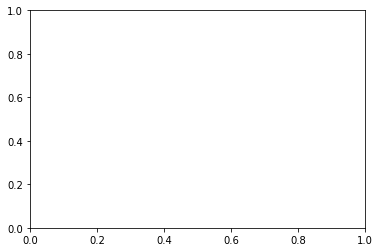

In [124]:
import matplotlib.pyplot as plt
# plot the results
plt.plot(knn,means)
plt.xlabel('Value of K for KNN')
plt.ylabel('F1 score based on Cross-Validation')
plt.show()

In [125]:
# identify the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.44648343973185645
{'n_neighbors': 3}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')


In [126]:
%%time
# train your model using all data and the best known parameters
#TODO: use best n_neighbors from grid search
knn = KNeighborsClassifier(n_neighbors=12, weights='uniform')
knn.fit(X, y)
y_pred =  knn.predict(X_test)

print(metrics.precision_score(y_test, y_pred, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred))

0.7742514377876609
0.7761506276150628
0.7737821589809037
[[257 127]
 [ 87 485]]
CPU times: user 20.8 s, sys: 180 ms, total: 21 s
Wall time: 21.1 s
